In [29]:
import gc
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import random

from os import path
from keras.utils import image_dataset_from_directory
from keras.applications.resnet import ResNet50, preprocess_input
from matplotlib import pyplot as plt
from keras import layers, losses, optimizers, metrics, callbacks

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=9048)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

0 Physical GPU, 0 Logical GPUs


In [9]:
SEED = 123
N_CLASS = 10
IMG_SIZE = 224

In [10]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [60]:
train_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'train.csv')).drop(["Unnamed: 0"], axis=1)
dataset_train = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'train'),
    labels=list(train_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_train = dataset_train.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

val_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'val.csv')).drop(["Unnamed: 0"], axis=1)
dataset_val = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'val'),
    labels=list(val_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_val = dataset_val.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

test_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'test.csv')).drop(["Unnamed: 0"], axis=1)

dataset_test = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'test'),
    labels=list(test_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_test = dataset_test.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

Found 35000 files belonging to 1 classes.
Found 5000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.


## ResNet

In [51]:
dataset_train_resnet = dataset_train.map(lambda x, y : (preprocess_input(x), y))
dataset_val_resnet = dataset_val.map(lambda x, y : (preprocess_input(x), y))
dataset_test_resnet = dataset_test.map(lambda x, y: (preprocess_input(x), y))

In [52]:
resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [53]:
for i, layer in enumerate(resnet.layers):
    if not layer.name.startswith('conv5'):
        resnet.get_layer(layer.name).trainable = False

resnet.get_layer('predictions').trainable = True

inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
outputs = keras.layers.Dense(10)(resnet(inputs))

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_3 (Dense)             (None, 10)                10010     
                                                                 
Total params: 25,646,722
Trainable params: 17,035,010
Non-trainable params: 8,611,712
_________________________________________________________________


## Simple data augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


151.06097


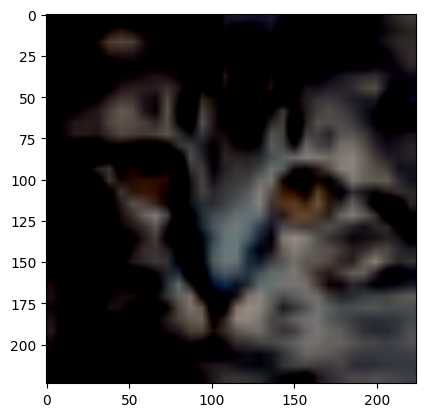

In [66]:
for img, label in dataset_train_resnet.take(1):
    print(img[0].numpy().max())
    plt.imshow(img[0].numpy().astype('int32'))

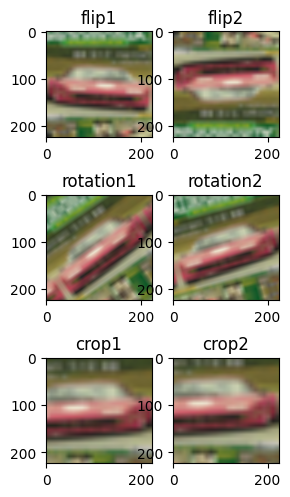

In [64]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

random_flip = layers.RandomFlip()
random_rotation = layers.RandomRotation(factor=(-0.3, 0.3))
random_crop = keras.Sequential([
    layers.RandomCrop(168, 168),
    layers.Resizing(IMG_SIZE, IMG_SIZE)])

augmentation_dict = {
    'flip' : random_flip,
    'rotation': random_rotation,
    'crop': random_crop
}

for imgs, labels in dataset_train.take(1):
    img = imgs[0]
    fig, ax = plt.subplots(3, 2, figsize=(3,6))
    for i, (name, transform) in enumerate(augmentation_dict.items()):
        for j in range(2):
            augmented = transform(tf.expand_dims(img, 0), training=True)
            ax[i][j].imshow(augmented[0].numpy().astype('int32'))
            ax[i][j].set_title(name + str(j+1))

In [ ]:
TRAINING_SEEDS = list(range(10))
results = []

early_stopping = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5, patience=5, min_lr=0.00001, verbose=1)


for name, transform in augmentation_dict.items():
    for seed in TRAINING_SEEDS:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)

        inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = transform(inputs)
        output = model(x)

        augmented_model = keras.Model(inputs, output)

        augmented_model.compile(
            optimizer=optimizers.Adam(),
            loss=losses.CategoricalCrossentropy(),
            metrics=[metrics.CategoricalCrossentropy(), metrics.CategoricalAccuracy()]
        )
        augmented_model.fit(
            dataset_train_resnet,
            epochs=200,
            validation_data=dataset_val_resnet,
            shuffle=True,
            callbacks=[early_stopping, reduce_lr]
        )
        eval_results = model.evaluate(dataset_test_resnet)
        results += [{
            'seed': seed,
            'transformation': name,
            'results': dict(zip(model.metrics_names, eval_results))
        }]
        gc.collect()

results = pd.DataFrame(results)
results = pd.concat([results.drop(["results"], axis=1), results["results"].apply(pd.Series)], axis=1)
results.to_csv('simple_augmentation_results.csv')

Epoch 1/200
 1/69 [..............................] - ETA: 4:07:37 - loss: 6.7831 - categorical_crossentropy: 6.7831 - categorical_accuracy: 0.0996